Parts of this notebook are taken from Andre Karpathy: https://github.com/karpathy/pytorch-normalizing-flows/blob/master/nflib1.ipynb
and have been modified. 

Embedding idea comes from Jan Francu who I am grateful to. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import torch
import itertools

In [2]:
ls

DiscreteFlowDemo.ipynb                  TestEmbedding-Figure2Replication.ipynb
Figure2Replication.ipynb                figures/
README.md                               nflib/


In [3]:
import os
os.chdir('nflib')

In [4]:
# importing all of the normalizing flows. 
import disc_utils
from MADE import *
from nets import MLP
from TorchDiscCode import *

In [5]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2

## Generating the training data. A 2D Mixture of 8 Gaussians. 
Storing the data as variable "data" which will then be sampled from. 

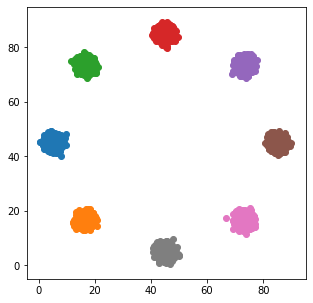

In [6]:
n_samps = 1000
means = ( (np.array([[3,5], [5-1.414,5-1.414], [5-1.414,5+1.414], [5, 7], [5+1.414,5+1.414], [7,5], [5+1.414,5-1.414], [5,3]  ])  )*20 ) -55
plt.figure(figsize=(5,5))
data = np.zeros((len(means)*n_samps,2))
for ind, m in enumerate(means):
    samps = multivariate_normal(m, np.eye(2)*2).rvs(n_samps)#.astype(int)
    data[ind*n_samps:((ind+1)*n_samps)] = samps
    plt.scatter(samps[:,0], samps[:,1])

## Converting data into onehot vectors
Need to define the vocabulary size to do this. 

In [7]:
def one_hotter(x, depth):
    idd = np.eye(depth)
    #print(idd[0])
    res = np.zeros((x.shape[0], x.shape[1], depth))
    #print(res.shape)
    for ind in range(len(x)): 
        for j, val in enumerate(x[ind]):
            if int(val) >= depth:
                val = depth-1
                #print(val)
            res[ind, j, :] = idd[int(val)]
    return res    

batch_size, sequence_length, vocab_size = 512, 2, 90

oh = one_hotter(data, vocab_size)

## Generating an example onehot sample of the data:

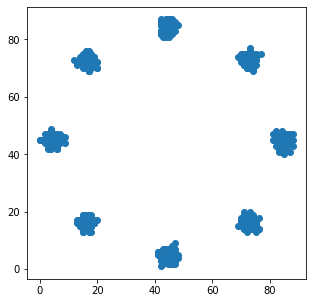

In [8]:
def oh_sample(batch_size):
    rand = np.random.choice(np.arange(len(oh)), batch_size)
    return oh[rand,:]

samps = oh_sample(1000).argmax(-1)
plt.figure(figsize=(5,5))
plt.scatter(samps[:,0], samps[:,1])

## Generating the model

In [25]:
num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
nh = 32 # number of hidden units per layer
vector_length = sequence_length*vocab_size
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'embedding' #'bipartite' #'autoreg'
flows = []

In [26]:
for i in range(num_flows):
    if disc_layer_type == 'autoreg':
        layer = MADE(vocab_size, [nh, nh, nh], vocab_size,
                     num_masks=1, natural_ordering=True)
        # if want to also learn the scale:
        # put MADE(vocab_size, [nh, nh, nh], 2*vocab_size, num_masks=1, natural_ordering=True)
        
        # if natural ordering is false then this only works for up to 4 layers!!!
        # TODO: fix this bug. 
        
        disc_layer = DiscreteAutoregressiveFlow( layer, temperature, 
                                                    vocab_size )
    
    elif disc_layer_type == 'bipartite':
        layer = MLP(vector_length//2, vector_length//2, nh)
        
        # to get the scale also, set: MLP(vector_length//2, vector_length, nh)
        # MLP defaults to the following architecture for each individual flow: 
        '''
        self.net = nn.Sequential(
            nn.Linear(nin, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nout),
        )
        '''
        
        disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, 
                                            vocab_size, vector_length)
        # i%2 flips the parity of the masking. It splits the vector in half and alternates
        # each flow between changing the first half or the second. 
    
    elif disc_layer_type == 'embedding':
        
        layer = torch.nn.Embedding(vector_length//2, vector_length//2)
        
        disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, 
                                               vocab_size, vector_length, embedding=True)
    
    flows.append(disc_layer)
    
model = DiscreteAutoFlowModel(flows)

## Generate the base distribution/prior.  

In [27]:
n_samps = 1000
data_samps = oh_sample(n_samps).argmax(-1) 

## Converting into a proper probability distribution

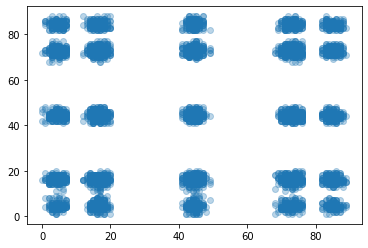

In [28]:
# learns the correct marginal distribution from the data. 
import collections
import pandas as pd
mod_data_dim0 = collections.Counter(data_samps[:,0])
mod_data_dim1 = collections.Counter(data_samps[:,1])
dim0_probs = np.zeros((vocab_size))
dim1_probs = np.zeros((vocab_size))
for k, v in mod_data_dim0.items():
    dim0_probs[k] = v/n_samps
for k, v in mod_data_dim1.items():
    dim1_probs[k] = (v/n_samps)

dim0_probs += 0.000001
dim1_probs += 0.000001

# need to renormalize again... 
dim0_probs = dim0_probs / np.sum(dim0_probs)
dim1_probs = dim1_probs / np.sum(dim1_probs)

mod_data_probs = torch.tensor( np.vstack([dim0_probs, dim1_probs]), requires_grad=False).float()

base = torch.distributions.OneHotCategorical( probs = mod_data_probs )
base_log_probs = torch.tensor( torch.log( base.probs).detach().numpy() , requires_grad=True)

samps = base.sample((10000,)).argmax(-1)
plt.scatter(samps[:,0], samps[:,1], label = 'shifted data', alpha=0.3)
plt.show()

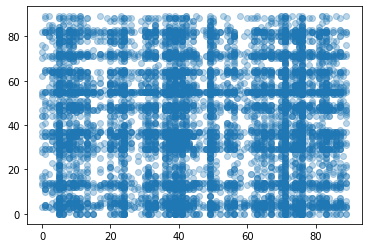

In [29]:
# if instead you want to start with a totally random prior distribution, uncomment
# and run this cell: 

base = torch.distributions.OneHotCategorical( logits = torch.randn( base_log_probs.shape) )
base_log_probs = torch.tensor( torch.log( base.probs).detach().numpy() , requires_grad=True)

samps = base.sample((10000,)).argmax(-1)
plt.scatter(samps[:,0], samps[:,1], label = 'shifted data', alpha=0.3)
plt.show()

epoch: 0 loss: 8.385882377624512
epoch: 20 loss: 8.060477256774902
epoch: 40 loss: 8.137398719787598
epoch: 60 loss: 8.357789039611816
epoch: 80 loss: 8.193697929382324
epoch: 100 loss: 8.111213684082031
epoch: 120 loss: 8.383624076843262
epoch: 140 loss: 7.979898452758789
epoch: 160 loss: 8.125300407409668
epoch: 180 loss: 8.291460990905762
epoch: 200 loss: 7.949214458465576
epoch: 220 loss: 8.065342903137207
epoch: 240 loss: 7.884129524230957
epoch: 260 loss: 7.988194465637207
epoch: 280 loss: 7.977619647979736


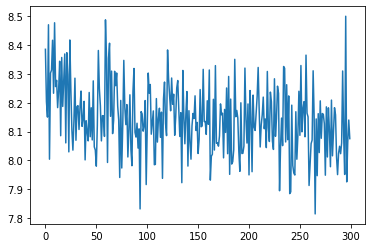

In [35]:
epochs = 300
learning_rate = 0.08
print_loss_every = 20

base_log_probs = torch.tensor( base.logits.detach().numpy() , requires_grad=True)

losses = []
optimizer = torch.optim.Adam( 
        [
            {'params': model.parameters() , 'lr':learning_rate},
            {'params': base_log_probs, 'lr': learning_rate }
        ])

model.train()
for e in range(epochs):
    x = torch.tensor(oh_sample(batch_size)).float()
    
    if disc_layer_type == 'bipartite' or disc_layer_type =='embedding':
        x= x.view(x.shape[0], -1) #flattening vector
    
    optimizer.zero_grad()
    zs = model.forward(x)
    
    if disc_layer_type == 'bipartite' or disc_layer_type =='embedding':
        zs = zs.view(batch_size, 2, -1) # flattening vector
    
    base_log_probs_sm = torch.nn.functional.log_softmax(base_log_probs, dim=-1)
    logprob = zs*base_log_probs_sm
    loss = -torch.sum(logprob)/batch_size
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if e%print_loss_every==0:
        print('epoch:', e, 'loss:', loss.item())

plt.plot(losses)

### Plot what the Prior looks like

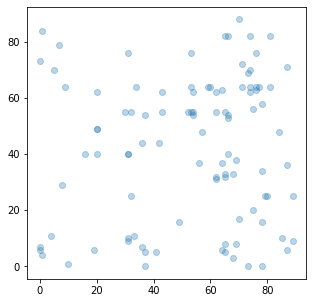

In [36]:
base = torch.distributions.OneHotCategorical( logits = base_log_probs )
plt.figure(figsize=(5,5))
samps = base.sample((100,)).argmax(-1)
plt.scatter(samps[:,0], samps[:,1], label = 'shifted data', alpha=0.3)
plt.show()

## Analyze model performance

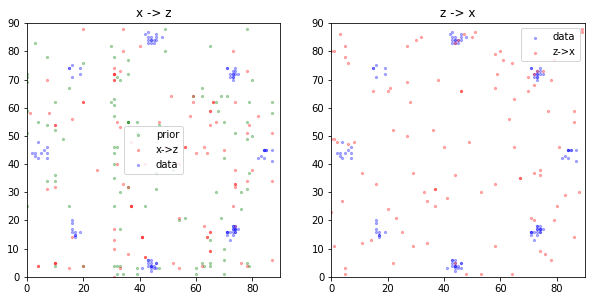

In [37]:
batch_size = 100
model.eval()
x = torch.tensor(oh_sample(batch_size)).float()
if disc_layer_type == 'bipartite' or disc_layer_type =='embedding':
    x = x.view(batch_size, -1)
zs = model.forward(x)
z = zs
if disc_layer_type == 'bipartite' or disc_layer_type =='embedding':
    z = z.view(batch_size, 2, -1)
    x = x.view(batch_size, 2, -1)

x = x.detach().numpy().argmax(-1)
z = z.detach().numpy().argmax(-1)
p = base.sample((batch_size,)).argmax(-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5, alpha=0.3)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.3)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])

if disc_layer_type == 'bipartite' or disc_layer_type =='embedding':
    z = model.reverse(base.sample((batch_size,)).float().view(batch_size, -1))
    z = z.view(batch_size, 2, -1)
else: 
    z = model.reverse(base.sample((batch_size,)).float())
z = z.detach().numpy().argmax(-1)
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.3)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])
plt.gcf().savefig('../figures/Fig2Reproduce.png', dpi=250)

### Plotting the Z->X
This does not look like how it is supposed to...

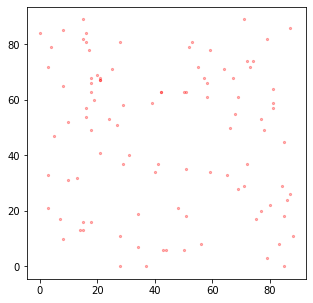

In [33]:
plt.figure(figsize=(5,5))
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)
plt.gcf().savefig('../figures/Fig2GeneratedSamples.png', dpi=250)
plt.show()

### Heatmap of the Z->X 
NB. The y axes is in the opposite direction

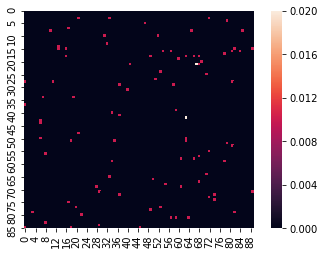

In [34]:
dim = base_log_probs.shape[-1]

heat = np.zeros((dim, dim))
for ind, ex in enumerate(z): 
    heat[ex[0], ex[1] ] += 1

heat = heat/ batch_size
import seaborn as sns;
sns.heatmap(heat, square=True)

### Plotting the Prior and X->Z

(1000, 2)


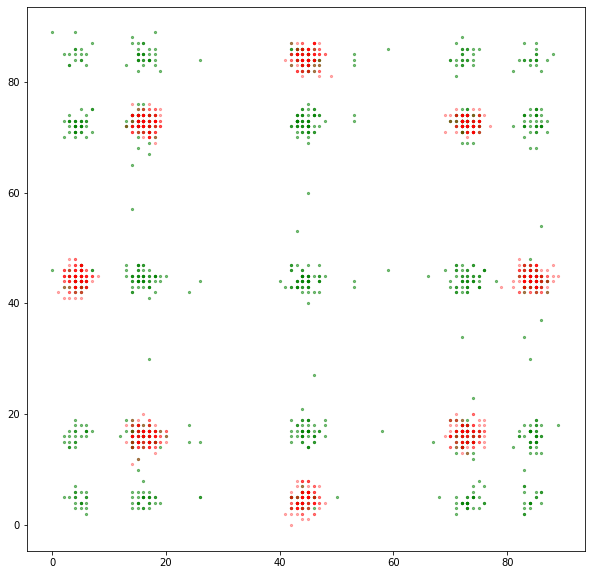

In [19]:
samp_batch_size = 1000
x = torch.tensor(oh_sample(samp_batch_size)).float()
if disc_layer_type == 'bipartite':
    x = x.view(samp_batch_size, -1)
z = model.forward(x)

if disc_layer_type == 'bipartite':
    z = z.view(samp_batch_size, 2, -1)
    x = x.view(samp_batch_size, 2, -1)

x = x.detach().numpy().argmax(-1)
z = z.detach().numpy().argmax(-1)
print(z.shape)
p = base.sample((samp_batch_size,)).argmax(-1)
plt.figure(figsize=(10,10))

plt.scatter(p[:,0], p[:,1], c='g', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)

### Heatmap of the Prior

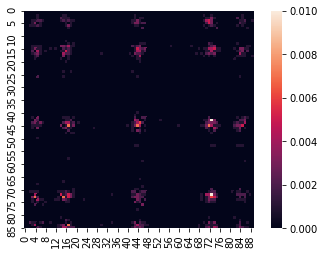

In [20]:
dim = base_log_probs.shape[-1]

heat = np.zeros((dim, dim))
for ind, ex in enumerate(p): 
    heat[ex[0], ex[1] ] += 1

heat = heat/ samp_batch_size
import seaborn as sns;
sns.heatmap(heat, square=True)

### Heatmap of X->Z
This should cover the highest probability regions. 

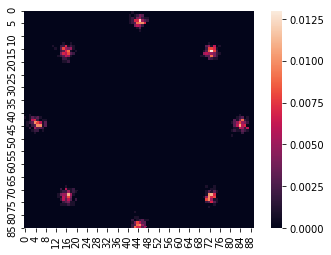

In [21]:
heat = np.zeros((dim, dim))
for ind, ex in enumerate(z): 
    heat[ex[0], ex[1] ] += 1
heat = heat/ samp_batch_size

import seaborn as sns;
sns.heatmap(heat, square=True)